In [1]:
import sys

sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
import torch.utils.data
import torchvision.transforms.functional as F
import matplotlib as mpl
from typing import Tuple
from PIL import Image

import transforms
import visualize

from brain_segmentation_pytorch.unet import UNet

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

## Dataset setup

In [3]:
classnames = {
    0: 'background',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'potted plant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tv/monitor'
}
CLASS_MAX=20

### Transforms

In [4]:
tr_inf = transforms.inference_transforms(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)
tr_img_inv = transforms.inv_normalize(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)

### Dataset loading

In [5]:
dataroot = '../data/'

In [6]:
ds_train = torchvision.datasets.wrap_dataset_for_transforms_v2(torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="train",
    download=False,
    transforms=tr_inf))


In [7]:
ds_val = torchvision.datasets.wrap_dataset_for_transforms_v2(torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="val",
    download=False,
    transforms=tr_inf))

In [8]:
len(ds_train)

1464

In [9]:
img, mask = ds_train[2]

In [10]:
img.shape

torch.Size([3, 256, 256])

In [11]:
img.device

device(type='cpu')

In [12]:
mask.shape

torch.Size([1, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


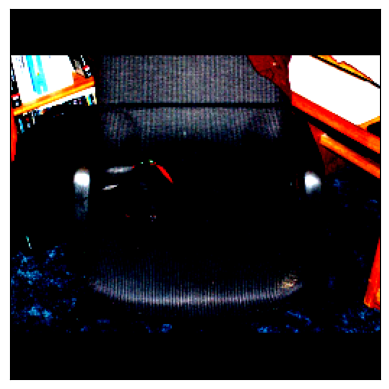

In [13]:
visualize.imshow_tensor(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


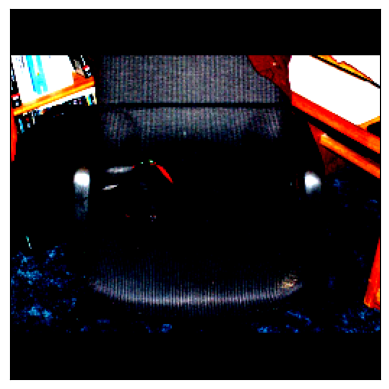

In [14]:
visualize.imshow_tensor(ds_train[2][0])

## Load Model

In [15]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
checkpointfile = "../checkpoints/test.chpt.pt"

In [17]:
# Model from checkpoint file
checkpoint = torch.load(checkpointfile)
unet_features = checkpoint['model_state_dict']['encoder1.enc1conv1.weight'].size(0)
model = UNet(
    in_channels=3,
    out_channels=CLASS_MAX+1,
    init_features=unet_features,
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.eval().to(device)

## Predictions

In [18]:
def topclass_dict(mask: torch.Tensor, k: int=4):
    pred_classes, counts = mask.unique(return_counts=True)
    topcounts, topcounts_idx = torch.topk(counts, min(k, len(counts)))
    #topclasses = pred_classes[topcounts_idx]

    top_k_classpixels = {
        classnames[pred_classes[i].item()] : counts[i].item()
        for i in topcounts_idx
    }

    return top_k_classpixels

In [19]:
def infer_ds_sample(sample: Tuple[torch.Tensor, torch.Tensor]):
    img, mask = sample
    img = img.unsqueeze(0)
    mask = mask[0,:].unsqueeze(0)

    with torch.no_grad():
        pred = model(img.to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred, dim=1)
        
        grid = visualize.make_comparison_grid(img=tr_img_inv(img), prediction=pred_amax, mask=mask)

    p = visualize.imshow_tensor(grid)
    top_k_classpixels = topclass_dict(pred_amax)


    return p, top_k_classpixels


### Training Set

(<matplotlib.image.AxesImage at 0x7fdecc740670>,
 {'background': 35486, 'chair': 20506, 'dog': 7768, 'tv/monitor': 1243})

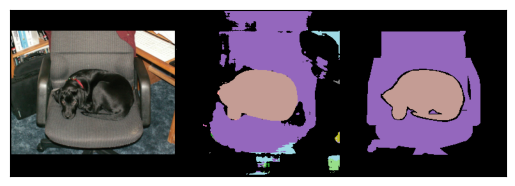

In [20]:
infer_ds_sample(ds_train[2])

(<matplotlib.image.AxesImage at 0x7fdeb4703190>,
 {'background': 28361, 'tv/monitor': 20606, 'boat': 9241, 'bus': 4341})

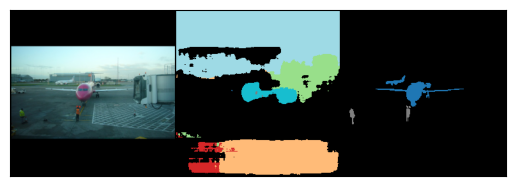

In [21]:
infer_ds_sample(ds_train[0])

### Custom Input

In [22]:
def infer_imgfile(path: str):
    with Image.open(path) as imgfile:
        img = tr_inf(imgfile)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred.squeeze(0), dim=0)
        
        grid = visualize.make_comparison_grid(img=tr_img_inv(img.unsqueeze(0)), prediction=pred_amax.unsqueeze(0))

    p = visualize.imshow_tensor(grid)
    top_k_classpixels = topclass_dict(pred_amax)

    return p, top_k_classpixels

{'background': 52657, 'person': 5450, 'tv/monitor': 5074, 'chair': 1884}

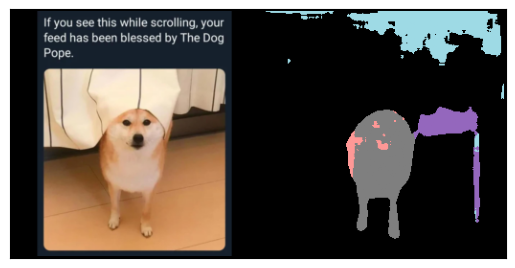

In [23]:
comp_img, classes = infer_imgfile(dataroot + "/mysamples/dogpope.jpg")
classes

{'background': 48786, 'person': 5586, 'tv/monitor': 3384, 'sheep': 2961}

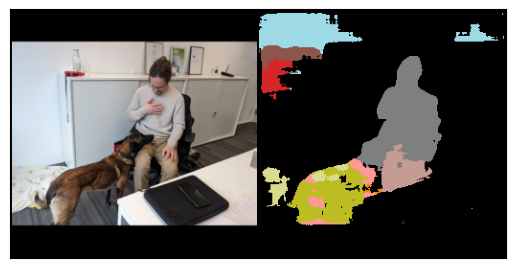

In [24]:
comp_img, classes = infer_imgfile(dataroot + "/mysamples/nelly1.jpg")
classes

{'background': 59674, 'tv/monitor': 4038, 'train': 905, 'dog': 362}

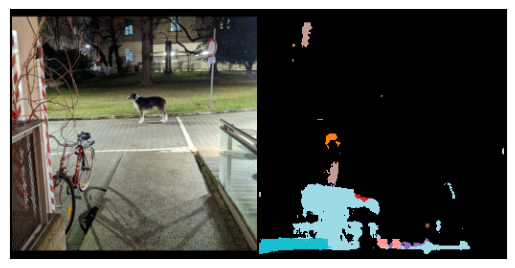

In [25]:
comp_img, classes = infer_imgfile(dataroot + "/mysamples/ghost1.jpg")
classes

{'background': 64835, 'cow': 512, 'sheep': 187, 'sofa': 1}

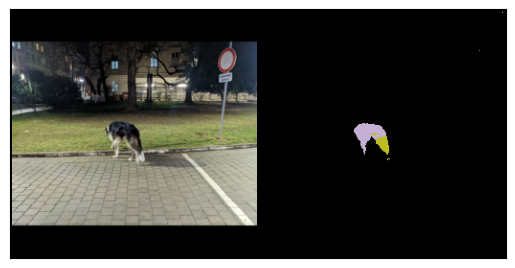

In [26]:
comp_img, classes = infer_imgfile(dataroot + "/mysamples/ghost2.jpg")
classes